<a href="https://colab.research.google.com/github/Canas-AlyssaVivien/BPNN/blob/main/Anime_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import joblib

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
df = pd.read_csv('anime.csv')
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

df.dropna(subset=['genre'], inplace=True)
df.reset_index(drop=True, inplace=True)

df['genre'] = df['genre'].str.strip()

mlb = MultiLabelBinarizer()
genres = mlb.fit_transform(df['genre'].str.split(', '))
genre_matrix = pd.DataFrame(genres, columns=mlb.classes_, index=df.index)

df = pd.concat([df, genre_matrix], axis=1)

last_genre_column_index = 49
df = df.iloc[:, :last_genre_column_index + 1]

df.head()

,anime_id,name,genre,type,episodes,rating,members,Action,Adventure,Cars,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
columns_to_drop = ['type', 'episodes', 'rating', 'members']
df = df.drop(columns=columns_to_drop, errors='ignore')
df.head()

,anime_id,name,genre,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,"Sci-Fi, Thriller",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.to_csv('processed_dataset.csv', index=False)

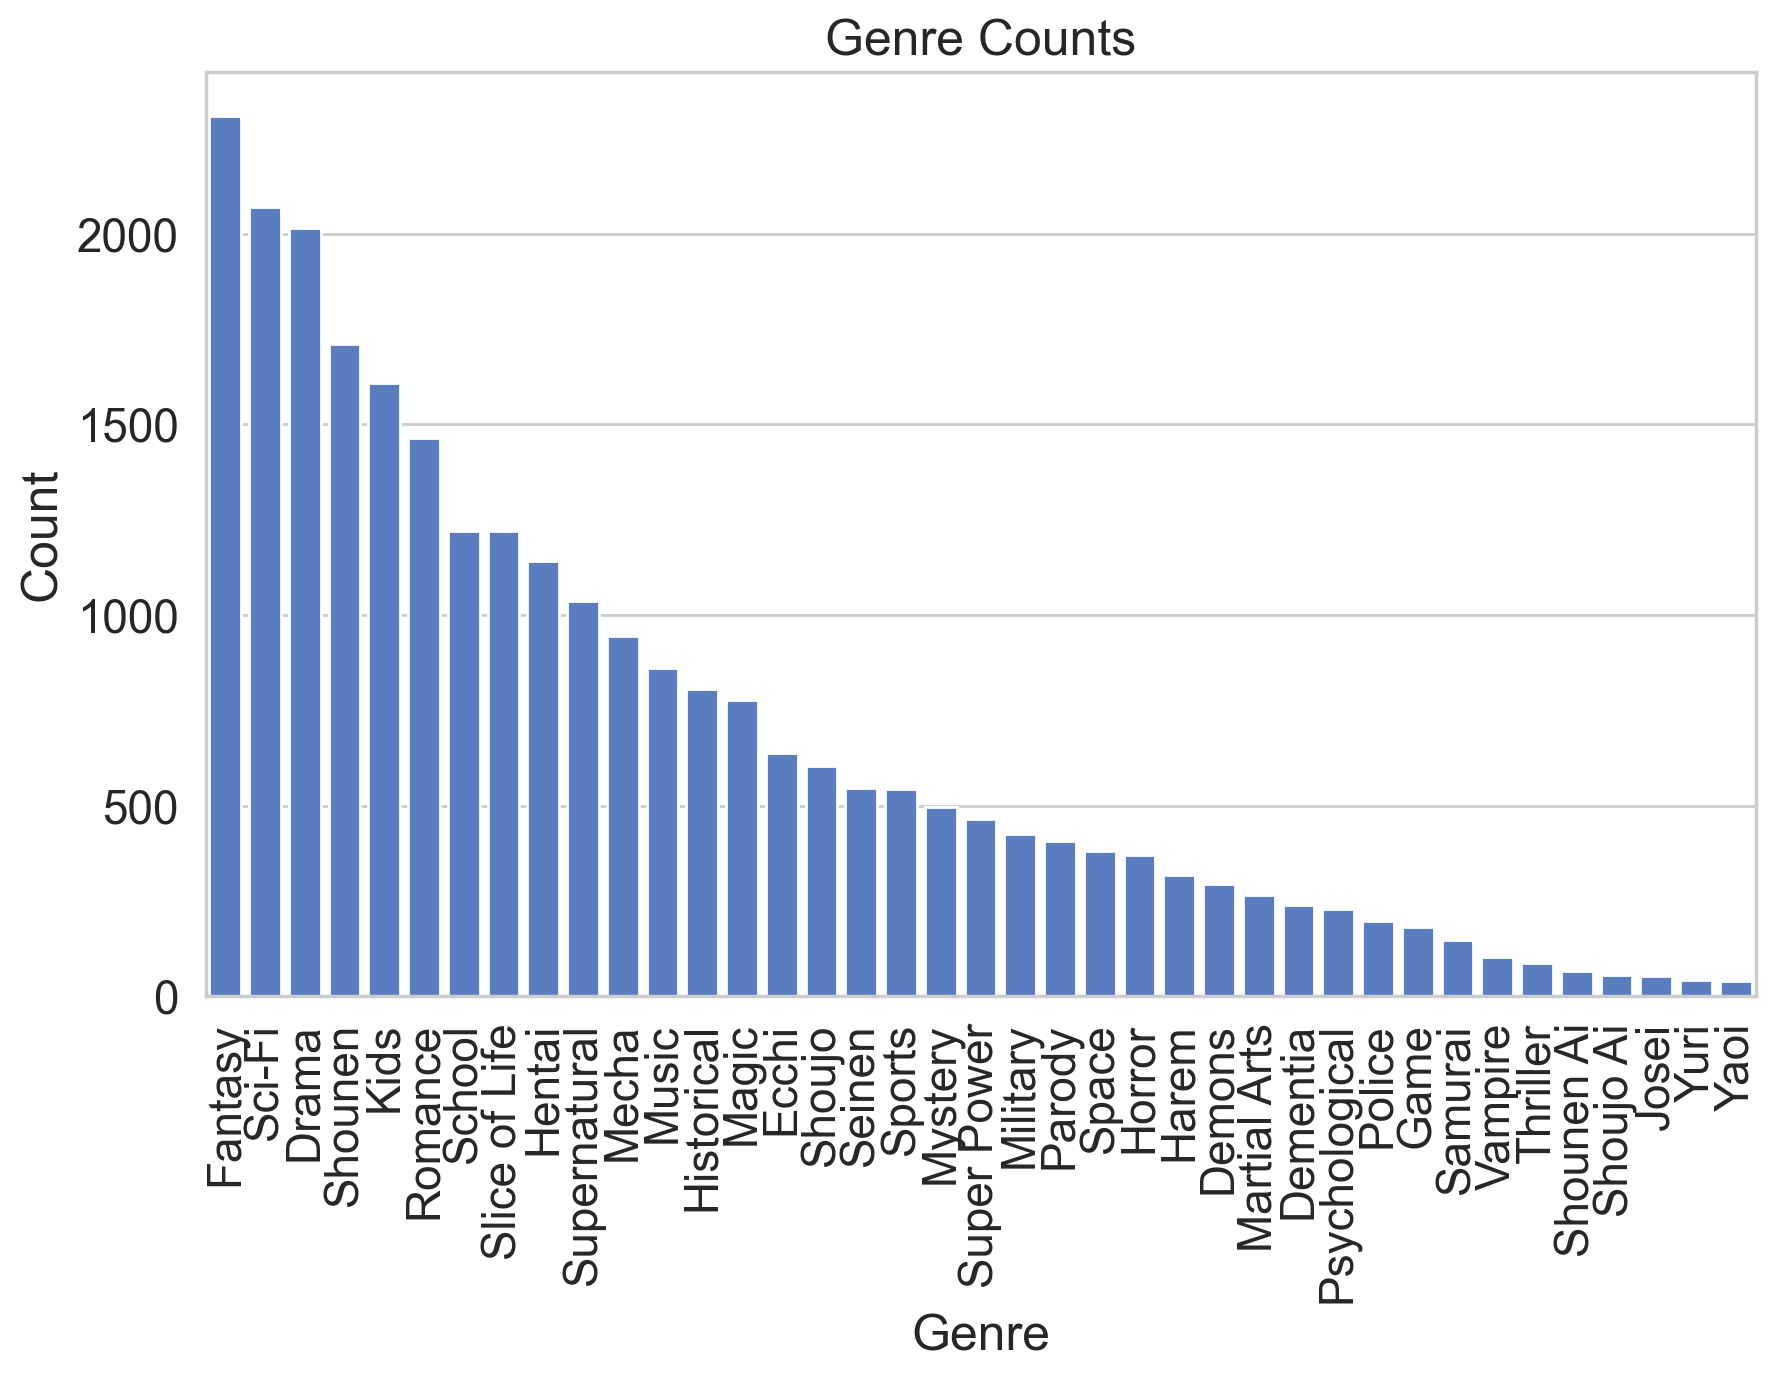

In [6]:
genre_counts = df.iloc[:, 7:].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Genre Counts')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['anime_id', 'name', 'genre'])
y = df.drop(columns=['anime_id', 'name', 'genre'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [8]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam

model = Sequential([
    Dense(units=45, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=y_train.shape[1], activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [9]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

model.save('anime_recommendation_model.h5')

Epoch 1/50



138/138 [==============================] - 1s 3ms/step - loss: 0.3190 - accuracy: 0.2046 - val_loss: 0.1612 - val_accuracy: 0.5475
Epoch 2/50
138/138 [==============================] - 0s 2ms/step - loss: 0.1703 - accuracy: 0.4283 - val_loss: 0.1047 - val_accuracy: 0.6016
Epoch 3/50
138/138 [==============================] - 0s 2ms/step - loss: 0.1379 - accuracy: 0.4805 - val_loss: 0.0788 - val_accuracy: 0.6108
Epoch 4/50
138/138 [==============================] - 0s 2ms/step - loss: 0.1227 - accuracy: 0.4963 - val_loss: 0.0663 - val_accuracy: 0.5894
Epoch 5/50
138/138 [==============================] - 0s 2ms/step - loss: 0.1139 - accuracy: 0.5095 - val_loss: 0.0588 - val_accuracy: 0.5812
Epoch 6/50
138/138 [==============================] - 0s 2ms/step - loss: 0.1084 - accuracy: 0.5067 - val_loss: 0.0545 - val_accuracy: 0.5853
Epoch 7/50
138/138 [==============================] - 0s 2ms/step - loss: 0.1039 - accuracy: 0.5124 - val_loss: 0.0514 - val_accuracy: 0.5894
Epoch 8/50
138/13

c:\Users\Alyssa Vivien\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


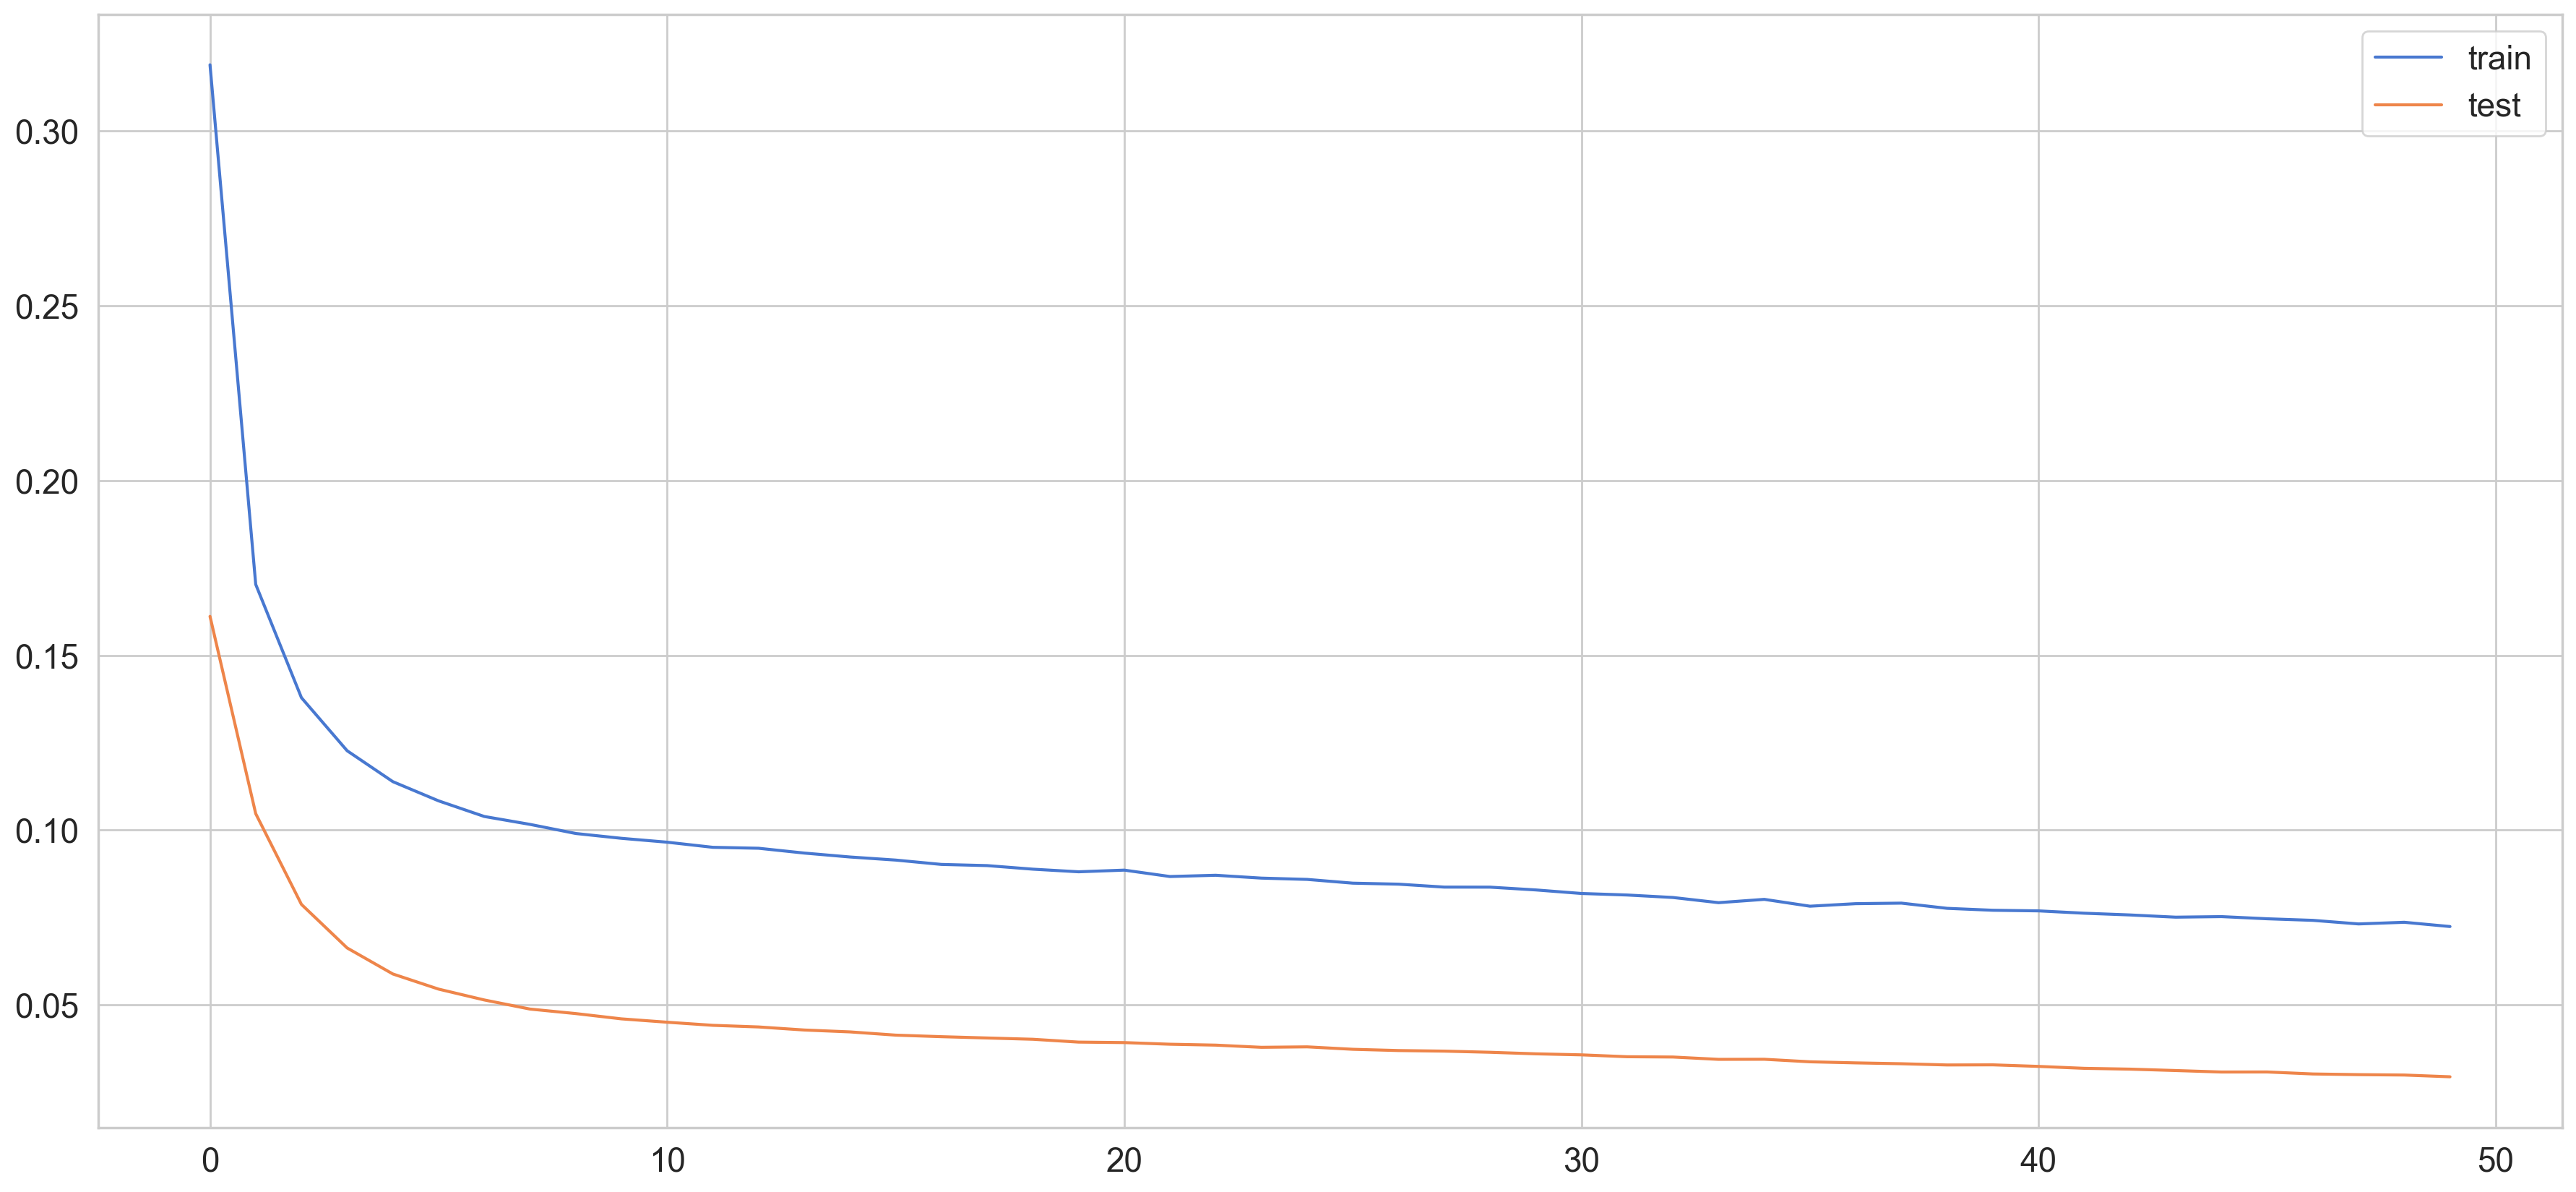

In [10]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [11]:
model.evaluate(X_test, y_test)

77/77 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.7168


[0.029011741280555725, 0.7167961001396179]

In [12]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_binary, target_names=y.columns))

77/77 [==============================] - 0s 2ms/step
               precision    recall  f1-score   support

       Action       0.98      0.98      0.98       564
    Adventure       0.99      0.97      0.98       469
         Cars       1.00      0.91      0.95        11
       Comedy       1.00      0.97      0.99       944
     Dementia       1.00      0.90      0.95        41
       Demons       1.00      0.20      0.33        65
        Drama       0.97      0.95      0.96       436
        Ecchi       0.98      0.81      0.89       137
      Fantasy       0.99      0.96      0.98       501
         Game       1.00      0.54      0.70        35
        Harem       0.95      0.60      0.73        60
       Hentai       1.00      0.94      0.97       218
   Historical       0.98      0.84      0.90       156
       Horror       0.96      0.65      0.77        68
        Josei       0.00      0.00      0.00        17
         Kids       1.00      0.97      0.99       310
        Mag

c:\Users\Alyssa Vivien\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alyssa Vivien\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
